In [49]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from matplotlib import pyplot as plt

from models.cir import CoxIngersollRossModel

warnings.simplefilter('ignore', FutureWarning)

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# US federal funds rate

In [51]:
df = pd.read_csv('./data_processing/data/fed-funds-rate-historical-chart.csv', parse_dates=[0])
df.columns = ['date', 'value']
df.head()

,date,value
0,1954-07-01,1.13
1,1954-07-02,1.25
2,1954-07-03,1.25
3,1954-07-04,1.25
4,1954-07-05,0.88


In [52]:
monthly_rate = df.groupby(
    df['date'].dt.strftime('%Y-%m-1')
)['value'].apply(lambda group: list(group)[0]).reset_index()
monthly_rate['date'] = pd.to_datetime(monthly_rate['date'])
monthly_rate.head()

,date,value
0,1954-07-01,1.13
1,1954-08-01,0.25
2,1954-09-01,1.44
3,1954-10-01,0.50
4,1954-11-01,1.38


In [53]:
monthly_rate = monthly_rate[(monthly_rate['date'].dt.year >= 2013) & (monthly_rate['date'].dt.month >= 9)]

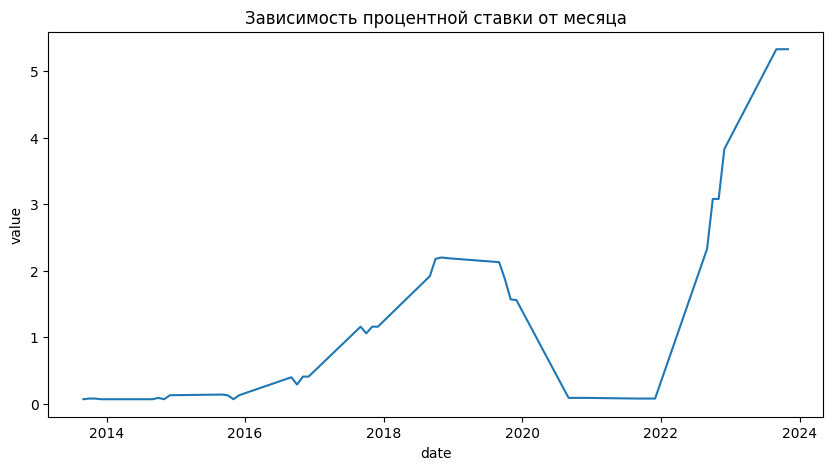

In [54]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_rate, x='date', y='value')
plt.title('Зависимость процентной ставки от месяца');

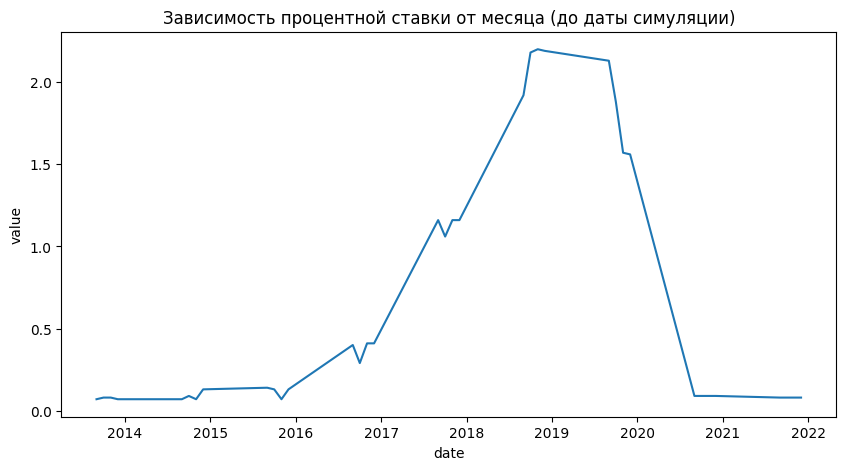

In [55]:
simulation_date = datetime.datetime(2021, 12, 10)
monthly_rate = monthly_rate[monthly_rate['date'] < simulation_date]
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_rate, x='date', y='value')
plt.title('Зависимость процентной ставки от месяца (до даты симуляции)');

In [59]:
cir = CoxIngersollRossModel()
cir.estimate_ols(monthly_rate['value'])
print(cir)

CIR(a=0.03820445827474804, b=0.6763357016070028, sigma=0.34030519063341663)


In [57]:
r_start = 0.07
N = 100
T = 24
simulated_rate, expected_value, expected_error = cir.make_interest_rate_simulations(r_start, N, T)
print("The expected value for the interest rate is:", "{}".format(expected_value))
print("The standard error of sample mean is:", "{}".format(expected_error))

The expected value for the interest rate is: 0.3976813098130127
The standard error of sample mean is: 0.06152839121676902


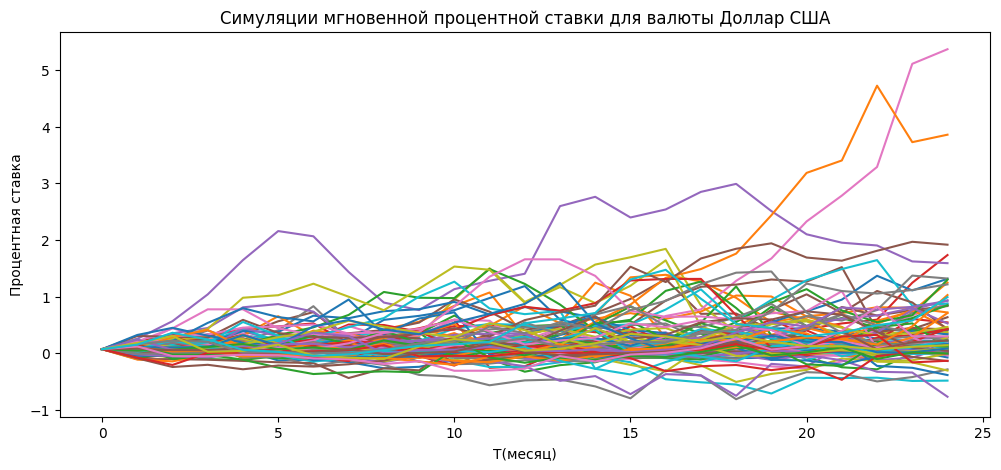

In [10]:
plt.figure(figsize=(12, 5))

for simulation in simulated_rate:
    plt.plot(np.arange(0, T + 1, 1), simulation)
plt.title('Симуляции мгновенной процентной ставки для валюты Доллар США')
plt.xlabel('T(месяц)')
plt.ylabel('Процентная ставка');

# US SOFR

In [16]:
df_sofr = pd.read_csv('./data_processing/data/SOFR.csv', parse_dates=['DATE'])
df_sofr.head()

,DATE,SOFR
0,2018-11-28,2.19
1,2018-11-29,2.24
2,2018-11-30,2.28
3,2018-12-03,2.23
4,2018-12-04,2.27


In [30]:
for row_index, row_data in df_sofr[df_sofr['SOFR'] == '.'].iterrows():
    df_sofr.loc[row_index, 'SOFR'] = (float(df_sofr.loc[row_index - 1, 'SOFR']) + float(df_sofr.loc[row_index + 1, 'SOFR'])) / 2
df_sofr['SOFR'] = df_sofr['SOFR'].astype(float)

In [31]:
monthly_rate_sofr = df_sofr.groupby(
    df_sofr['DATE'].dt.strftime('%Y-%m-1')
)['SOFR'].apply(lambda group: list(group)[0]).reset_index()
monthly_rate_sofr['DATE'] = pd.to_datetime(monthly_rate_sofr['DATE'])
monthly_rate_sofr.head()

,DATE,SOFR
0,2018-11-01,2.190
1,2018-12-01,2.230
2,2019-01-01,3.075
3,2019-02-01,2.470
4,2019-03-01,2.380


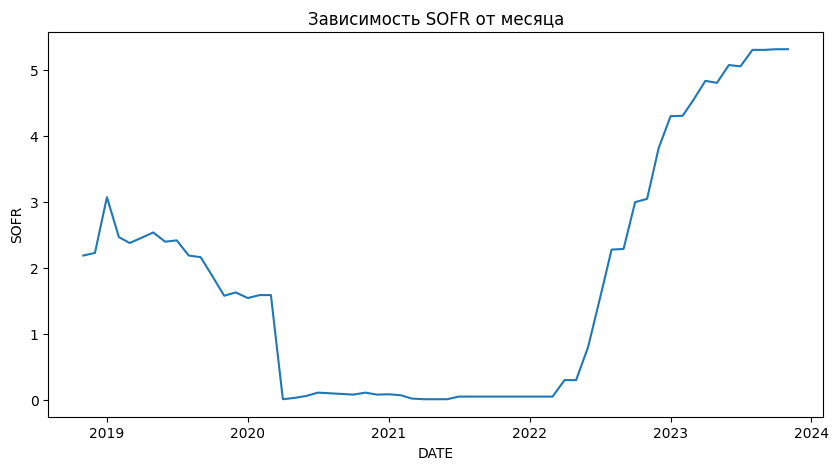

In [33]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_rate_sofr, x='DATE', y='SOFR')
plt.title('Зависимость SOFR от месяца');

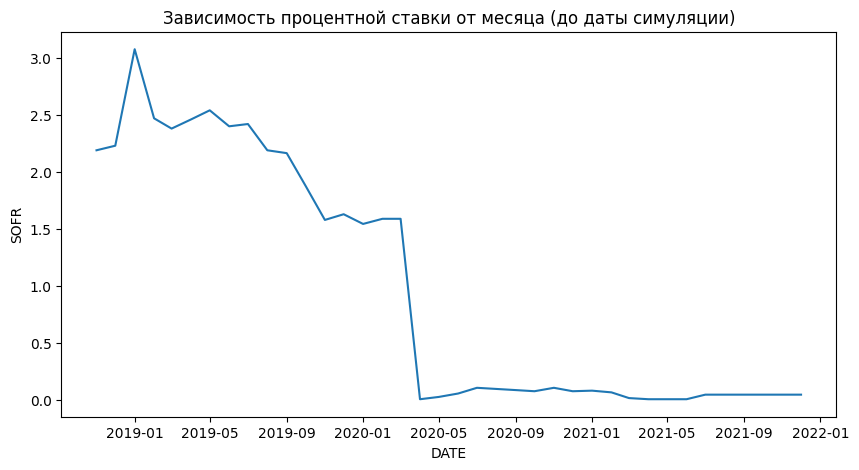

In [34]:
simulation_date = datetime.datetime(2021, 12, 10)
monthly_rate_sofr = monthly_rate_sofr[monthly_rate_sofr['DATE'] < simulation_date]
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_rate_sofr, x='DATE', y='SOFR')
plt.title('Зависимость процентной ставки от месяца (до даты симуляции)');

In [60]:
cir_sofr = CoxIngersollRossModel()
cir_sofr.estimate_ols(monthly_rate_sofr['SOFR'])
print(cir_sofr)

CIR(a=0.06789810841840623, b=0.16059960254819342, sigma=0.24813593481679308)


In [61]:
cir_sofr.optimize_negative_likelihood(monthly_rate_sofr['SOFR'])

/Users/m1crozavr/anaconda3/envs/hse-ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/m1crozavr/anaconda3/envs/hse-ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/m1crozavr/anaconda3/envs/hse-ml/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/m1crozavr/anaconda3/envs/hse-ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/m1crozavr/anaconda3/envs/hse-ml/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/m1crozavr/anaconda3/envs/hse-ml/lib/python3.

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -306.41832374050466
        x: [ 9.369e-05  3.583e-01  1.944e-04]
      nit: 12
      jac: [ 2.455e+05  5.262e+01  7.708e+04]
 hess_inv: [[ 1.864e-10 -1.051e-07  1.517e-10]
            [-1.051e-07  6.231e-04  7.485e-08]
            [ 1.517e-10  7.485e-08  8.538e-10]]
     nfev: 373
     njev: 91

In [62]:
r_start_sofr = 0.05
N = 100
T = 24
simulated_rate_sofr, expected_value_sofr, expected_error_sofr = cir.make_interest_rate_simulations(r_start_sofr, N, T)
print("The expected value for the interest rate SOFR is:", "{}".format(expected_value_sofr))
print("The standard error of sample mean is:", "{}".format(expected_error_sofr))

The expected value for the interest rate SOFR is: 0.4754342780208807
The standard error of sample mean is: 0.08078444298076348


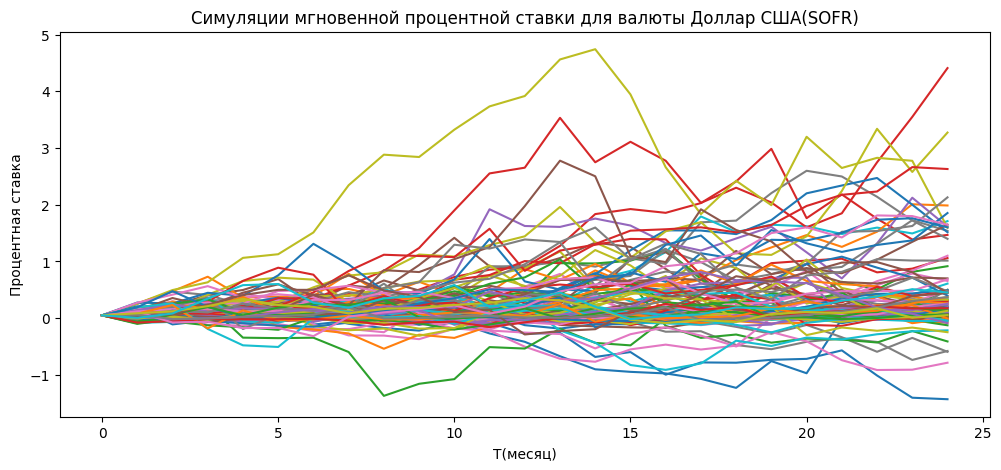

In [63]:
plt.figure(figsize=(12, 5))

for simulation in simulated_rate_sofr:
    plt.plot(np.arange(0, T + 1, 1), simulation)
plt.title('Симуляции мгновенной процентной ставки для валюты Доллар США(SOFR)')
plt.xlabel('T(месяц)')
plt.ylabel('Процентная ставка');